### Importing the libraries

In [37]:
#Import all relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Loading the data

In [38]:
#Load the file into pandas
df = pd.read_excel(r'./dataset-3.xlsx')

#check first 5 rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [39]:
#使用該info() 方法，我們可以檢查數據集的結構，包括行數和列數，以及每列的名稱和數據類型以及它們是否包含空值。
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### 處理數據

In [40]:
#Check for null values
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

該數據集總共包含 136,534 個空值，其中絕大多數出現在 CustomerID 列中。由於我們有足夠的數據用於分析，因此我們不會費心嘗試估算這些缺失值，而只是將它們從數據中刪除。

In [41]:
#Drop all rows with a null value
df.dropna(inplace=True)
len(df)

406829

刪除所有空值後，我們剩下 406,829 行數據。接下來，我們要從數據中刪除所有已取消的交易。請記住，從數據集的描述中可以看出，以“C”開頭的發票編號是已取消/已退回的交易。我們可以通過首先將 InvoiceNo 列轉換為字符串數據類型，然後使用簡單的過濾器刪除所有以“C”開頭的行來輕鬆刪除它們。

In [42]:
#Convert the InvoiceNo column to string
df["InvoiceNo"] = df["InvoiceNo"].astype('str')

#Remove rows with invoices that contain a "C"
df = df[~df["InvoiceNo"].str.contains("C")]

len(df)

397924

刪除所有已取消的交易後，我們剩下 397,924 行數據。我們最後的準備任務是只選擇一個國家的交易進行分析。在我們這樣做之前，我們可以先檢查所有交易是如何使用該value_counts()方法按國家/地區分佈的。為了便於查看，我們將其限制在前 10 個國家/地區。

In [43]:
#Check the distribution of transactions per country
top10 = df["Country"].value_counts().head(10)
print(top10)

United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Netherlands         2363
Belgium             2031
Switzerland         1842
Portugal            1462
Australia           1185
Name: Country, dtype: int64


就交易數量而言，英國顯然是第一名。我們也可以在餅圖中可視化此信息。

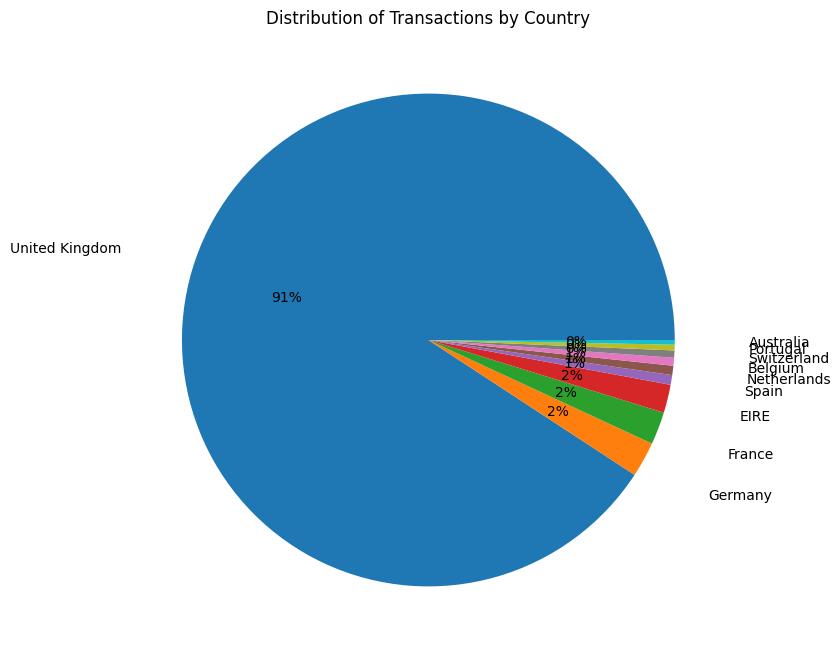

In [44]:
#Create a pie chart to show distribution of transactions
plt.figure(figsize=[8,8])
plt.pie(top10,labels=top10.index, autopct = '%0.0f%%',labeldistance=1.3)
plt.title("Distribution of Transactions by Country")
plt.show()

Text(0.5, 1.0, 'Spending per Country')

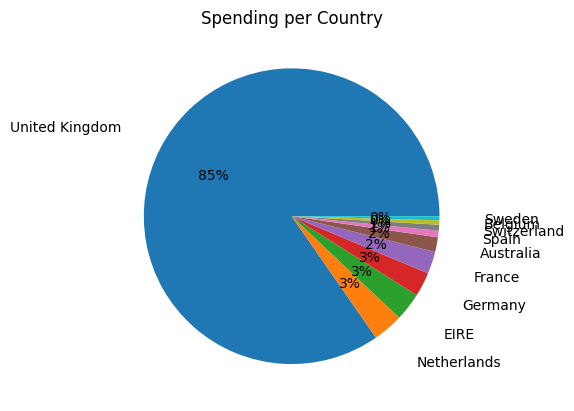

In [48]:
#spending per country
df['Amount'] = df['Quantity'] * df['UnitPrice']
countryspend = df.groupby("Country")["Amount"].sum().sort_values(ascending=False).head(10)
plt.pie(countryspend,labels=countryspend.index, autopct = '%0.0f%%',labeldistance=1.3)
plt.title("Spending per Country")

高達 91% 的交易來自英國。為簡單起見，我們將僅對英國進行分析。
我們還需要按交易 (InvoiceNo) 和項目 (Description) 對數據進行分組。
這將顯示購買的每件商品的數量。然後我們需要對這些值求和並拆開它們。
最後，我們將數據框的索引更改為 InvoiceNo，以顯示每筆交易購買的每件商品的數量。
我們可以按照下面的代碼在一行代碼中完成所有這些。



In [49]:
#Group, sum, unstack and set index of dataframe
basket = df[df['Country'] =="United Kingdom"]\
        .groupby(['InvoiceNo', 'Description'])["Quantity"]\
        .sum().unstack()\
        .reset_index().fillna(0)\
        .set_index("InvoiceNo")

basket.head()

#想問如何看到整個完整的數據 我想看到中間的值?

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


這是前五行的樣子。請注意，目前預覽中只有零，但如果您查看整個數據集，您也會注意到一些其他值。

我們的下一個任務是熱編碼我們的數據。為此，我們可以創建一個簡單的函數，將任何大於零的值轉換為 1，將任何零轉換為 0。然後我們可以使用該applymap()方法應用該函數。

In [50]:
#Create function to hot encode the values
def encode_values(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#Apply function to data
basket_encoded = basket.applymap(encode_values)

basket_encoded

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


最後我們刪除只有購買一項產品的發票。
因為我們分析的是一起購買的物品，因此單項發票對我們沒有用處。

In [51]:
#filter for only invoices with 2 or more items
basket_filtered = basket_encoded[(basket_encoded > 0).sum(axis=1) >= 2]

basket_filtered

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


我們現在減少到 15376 行數據，比熱編碼後的 16649 行減少了 7.65%。
這意味著 92.35% 的數據代表兩個或多個事務。現在數據已準備好且結構正確，我們可以開始執行我們的購物籃分析。

### 應用先驗算法

在本節中，我們將應用先驗算法來查找數據集中最常購買的商品。
對於我們的最小支持值，我們將指定 3%，這意味著僅返回數據中出現頻率至少為 3% 的項目。

In [52]:
#1a. Find frequent itemsets
frequent_itemsets = apriori(basket_filtered, min_support=0.03, use_colnames=True).sort_values("support",ascending=False)
frequent_itemsets.head(10)

/home/inl-06/anaconda3/envs/env_pytorch/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
99,0.121358,(WHITE HANGING HEART T-LIGHT HOLDER)
44,0.093197,(JUMBO BAG RED RETROSPOT)
80,0.090466,(REGENCY CAKESTAND 3 TIER)
6,0.084417,(ASSORTED COLOUR BIRD ORNAMENT)
71,0.082986,(PARTY BUNTING)
58,0.072841,(LUNCH BAG RED RETROSPOT)
86,0.064971,(SET OF 3 CAKE TINS PANTRY DESIGN )
52,0.064646,(LUNCH BAG BLACK SKULL.)
69,0.061004,(PAPER CHAIN KIT 50'S CHRISTMAS )
64,0.060939,(NATURAL SLATE HEART CHALKBOARD )


從結果中我們可以看出，“白色掛心 T 型燈架”是最常購買的商品，支持值為 0.121358，這意味著它在所有交易中的購買率為 12%。

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '2011-11'),
  Text(1, 0, '2011-10'),
  Text(2, 0, '2011-09'),
  Text(3, 0, '2011-05'),
  Text(4, 0, '2011-06'),
  Text(5, 0, '2011-03'),
  Text(6, 0, '2011-08'),
  Text(7, 0, '2011-07'),
  Text(8, 0, '2010-12'),
  Text(9, 0, '2011-04'),
  Text(10, 0, '2011-01'),
  Text(11, 0, '2011-02'),
  Text(12, 0, '2011-12')])

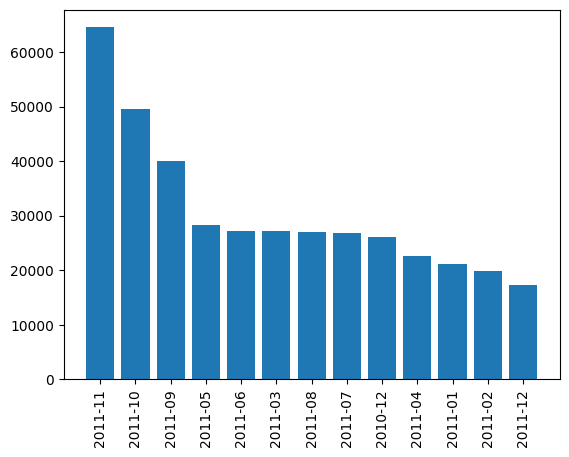

In [53]:
#1b. number of transactions
# per month
df['InvoiceDate'].dt.to_period('M').value_counts()
plt.bar(df['InvoiceDate'].dt.to_period('M').value_counts().index.astype(str),df['InvoiceDate'].dt.to_period('M').value_counts())
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Thursday'),
  Text(1, 0, 'Wednesday'),
  Text(2, 0, 'Tuesday'),
  Text(3, 0, 'Monday'),
  Text(4, 0, 'Sunday'),
  Text(5, 0, 'Friday')])

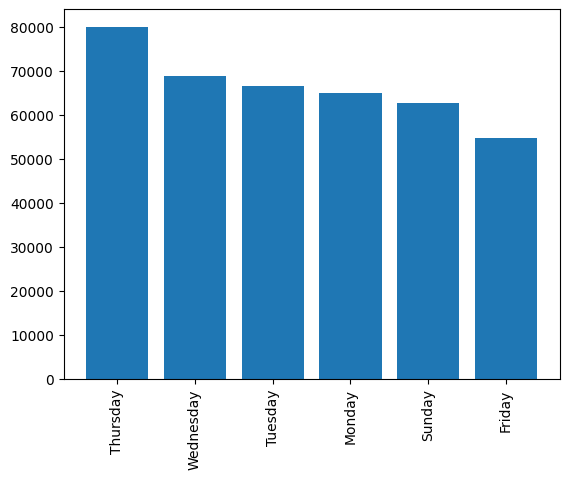

In [54]:
#1b. number of transactions
# weekdays
df['InvoiceDate'].dt.day_name().value_counts()
plt.bar(df['InvoiceDate'].dt.day_name().value_counts().index.astype(str),df['InvoiceDate'].dt.day_name().value_counts())
plt.xticks(rotation=90)

<BarContainer object of 15 artists>

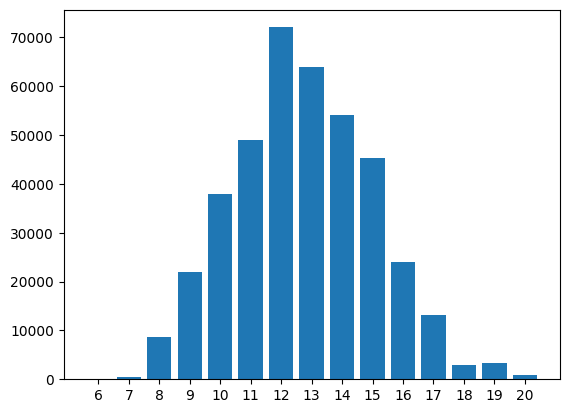

In [55]:
#1b. number of transactions
# hours
df['InvoiceDate'].dt.hour.value_counts().sort_index()
plt.bar(df['InvoiceDate'].dt.hour.value_counts().sort_index().index.astype(str),df['InvoiceDate'].dt.hour.value_counts().sort_index())

In [56]:
#1c. number of customers
df['CustomerID'].nunique()

4339

In [60]:
# sort customer spending
df.groupby('CustomerID')['Amount'].sum().sort_values(ascending=False)

CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
14911.0    143825.06
             ...    
17956.0        12.75
16454.0         6.90
14792.0         6.20
16738.0         3.75
13256.0         0.00
Name: Amount, Length: 4339, dtype: float64

In [58]:
#1d. number of items
df['StockCode'].nunique()

3665

In [61]:
# item purchase frequency
df['StockCode'].value_counts().sort_values(ascending=False)

85123A    2035
22423     1724
85099B    1618
84879     1408
47566     1397
          ... 
20678        1
47503J       1
90026A       1
90176C       1
23843        1
Name: StockCode, Length: 3665, dtype: int64

In [62]:
# item purchase quantity
df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False)

StockCode
23843     80995
23166     77916
84077     54415
22197     49183
85099B    46181
          ...  
90178B        1
85170A        1
90054         1
90055         1
35004P        1
Name: Quantity, Length: 3665, dtype: int64

### 應用關聯規則

我們分析的最後一步是生成規則及其相應的支持度、置信度和提升度。
然後，我們可以從中提取有關哪些商品更有可能一起購買的有用信息。

In [59]:
#Apply association rules
assoc_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values("lift",ascending=False).reset_index(drop=True)
assoc_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.039802,0.043900,0.030957,0.777778,17.717202,0.029210,4.302452
1,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.043900,0.039802,0.030957,0.705185,17.717202,0.029210,3.256952
2,(LUNCH BAG RED RETROSPOT),(LUNCH BAG PINK POLKADOT),0.072841,0.055086,0.030632,0.420536,7.634188,0.026620,1.630668
3,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.055086,0.072841,0.030632,0.556080,7.634188,0.026620,2.088574
4,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.052680,0.093197,0.032908,0.624691,6.702899,0.027999,2.416152
5,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.093197,0.052680,0.032908,0.353105,6.702899,0.027999,1.464412
6,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.064646,0.072841,0.031478,0.486922,6.684737,0.026769,1.807051
7,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.072841,0.064646,0.031478,0.432143,6.684737,0.026769,1.647164


根據執行關聯規則的結果，我們可以看到“Roses Regency Teacup and Saucer”和“Green Regency Teacup and Saucer”具有最高的“lift”值，因此在任何兩個產品中關聯度最高。綜合支持度為 0.0309，這意味著這兩種商品在所有交易中的 3.09% 是一起購買的。

至於利用這種洞察力實施什麼樣的營銷策略，這將取決於多種因素，並且是零售領域知識如何派上用場的完美示例。鑑於這是一家在線商店，很容易將每個後續產品顯示為先前產品頁面上的推薦，從而利用一種產品的受歡迎程度來推動另一種產品的銷售。另一種吸引更多銷售的方法是將相關產品捆綁在一起，並圍繞這兩種產品實施捆綁定價技術或促銷活動。

### 結論

在本文中，我們使用先驗算法和關聯規則成功地對零售數據集實施了購物籃分析。這個過程的很大一部分是它相對容易實施和解釋，其結果可用於製定數據驅動的戰略營銷決策。除了對零售商有用之外，購物籃分析還適用於其他領域，例如在製造業中對設備故障進行預測分析，在製藥行業中發現診斷與活性成分之間的共現關係，以及在金融領域進行欺詐檢測。